# Различные генераторы начальных значений

In [48]:
import numpy as np
import matplotlib.pyplot as plt
n_data = 100
n_cent = 6

In [6]:
def random_generate(n_samples, generate_box=(-10, 10)):
    sys = np.random.random_sample(n_samples * 2) * (generate_box[1] - generate_box[0]) + generate_box[0]
    return sys.reshape(-1, 2)

In [12]:
def qube_generate(n_centers = 1,n_samples = 0, center_box = (-10,10), cube_side = (2, 5)):
    center = np.random.random_sample(n_centers * 2) * (center_box[1] - center_box[0]) + center_box[0]
    center = center.reshape(-1, 2)
    box_size = np.random.random_sample(n_centers) * (cube_side[1] - cube_side[0]) + cube_side[0]
    samples_in_box = int(n_samples / n_centers)
    x = ((np.random.random_sample(samples_in_box * 2) - 0.5) * box_size[0]).reshape(-1, 2)
    x[:, 0] += center[0][0]
    x[:, 1] += center[0][1]
    n_samples -= samples_in_box
    for i in range(1, n_centers):
        samples_in_box = int(n_samples / (n_centers - i))
        n_samples -= samples_in_box
        tmp = ((np.random.random_sample(samples_in_box * 2) - 0.5) * box_size[i]).reshape(-1, 2)
        tmp[:, 0] += center[i][0]
        tmp[:, 1] += center[i][1]
        x = np.concatenate([x, tmp])
    return x

In [13]:
def circle_generate(n_centers = 1, n_samples = 0, center_box = (-10, 10), border_of_radius = (2, 5)):
    center = np.random.random_sample(n_centers * 2) * (center_box[1] - center_box[0]) + center_box[0]
    center = center.reshape(-1, 2)
    radius = np.random.random_sample(n_centers) * (border_of_radius[1] - border_of_radius[0]) + border_of_radius[0]
    samples_in_circle = int(n_samples / n_centers)
    res = np.zeros(samples_in_circle * 2).reshape(-1, 2)
    x = np.random.random_sample(samples_in_circle * 2).reshape(-1, 2)
    x[:, 0] *= radius[0]
    x[:, 1] *= 2 * np.pi
    res[:, 0] = x[:, 0] * np.cos(x[:, 1]) + center[0][0]
    res[:, 1] = x[:, 0] * np.sin(x[:, 1]) + center[0][1]
    n_samples -= samples_in_circle
    for i in range(1, n_centers):
        samples_in_circle = int(n_samples / (n_centers - i))
        n_samples -= samples_in_circle
        x = np.random.random_sample(samples_in_circle * 2).reshape(-1, 2)
        x[:, 0] *= radius[i]
        x[:, 1] *= 2 * np.pi
        tmp = np.zeros(samples_in_circle * 2).reshape(-1, 2)
        tmp[:, 0] = x[:, 0] * np.cos(x[:, 1]) + center[i][0]
        tmp[:, 1] = x[:, 0] * np.sin(x[:, 1]) + center[i][1]
        res = np.concatenate([res, tmp])
    return res

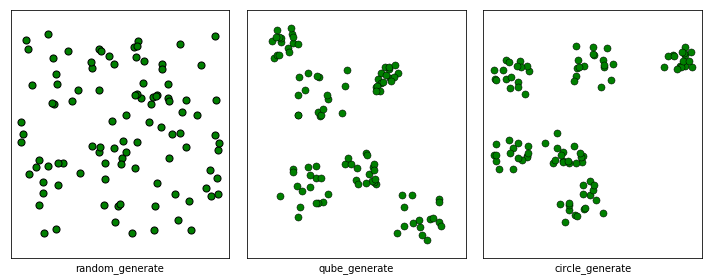

In [51]:
blobs1 = random_generate(n_samples = n_data, generate_box = (-14, 14))
blobs2 = qube_generate(n_samples = n_data, n_centers = n_cent)
blobs3 = qube_generate(n_samples = n_data, n_centers = n_cent)

figure = plt.figure(figsize=(10, 4))

plt.subplot(131)
plt.scatter(blobs1[:, 0], blobs1[:, 1], c='green', s=50, cmap='Blues', edgecolors='black', linewidth=1.0)
plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.xlabel('random_generate')
plt.subplot(132)
plt.scatter(blobs2[:, 0], blobs2[:, 1], c='green', s=50, cmap='Blues', edgecolors='black', linewidth=0.5)
plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.xlabel('qube_generate')
plt.subplot(133)
plt.scatter(blobs3[:, 0], blobs3[:, 1], c='green', s=50, cmap='Blues', edgecolors='black', linewidth=0.5)
plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.xlabel('circle_generate')
plt.tight_layout()

# Выбор начальных точек

In [24]:
def random_KMeans_cent(sys, sys_size, centers):
    cent = np.empty(centers * 2).reshape(-1, 2)
    cent[range(centers), :] = sys[np.random.choice(range(sys_size), centers, replace=False)]
    return cent

In [18]:
def choise_KMeans_centers(sys, sys_size, centers):
    mask = np.full(sys_size, 1)
    distance = (sys[:, 0][:, np.newaxis] - sys[:, 0]) ** 2
    distance += (sys[:, 1][:, np.newaxis] - sys[:, 1]) ** 2
    distance = np.sqrt(distance)
    D_sum = np.sum(distance, axis=1)
    cent = sys[np.argmax(D_sum), :]
    mask[np.argmax(D_sum)] = 0
    cent = np.concatenate([cent, sys[np.argmax(distance[np.argmax(D_sum), :])]]).reshape(2, 2)
    mask[np.argmax(distance[np.argmax(D_sum), :])] = 0
    if centers == 2:
        return cent
    for i in range(2, centers):
        distance = (sys[:, 0][:, np.newaxis] - cent[:, 0]) ** 2
        distance += (sys[:, 1][:, np.newaxis] - cent[:, 1]) ** 2
        distance = np.sqrt(distance)
        D_sum = np.sum(distance, axis=1)
        D_sum *= mask
        cent = np.concatenate((cent, sys[np.argmax(D_sum), :].reshape(1, 2)), axis=0)
        mask[np.argmax(D_sum)] = 0
    return cent

# Реализация KMeans

In [3]:
def KMeans(sys, sys_size, centers):
    cent = choise_KMeans_centers(sys=sys, sys_size=sys_size, centers=centers)
    distance = (sys[:, 0][:, np.newaxis] - cent[:, 0]) ** 2
    distance += (sys[:, 1][:, np.newaxis] - cent[:, 1]) ** 2
    distance = np.sqrt(distance)
    clasters_args = np.argmin(distance, axis=1)
    while True:
        new_cent = np.zeros(centers * sys_size * 2).reshape(-1, sys_size, 2)
        new_cent[clasters_args, range(sys_size), :] += sys[range(sys_size), :]
        new_cent = np.sum(new_cent, axis=1)
        new_cl_args, count = np.unique(clasters_args, return_counts=True)
        new_cent[:, 0] /= count
        new_cent[:, 1] /= count
        if np.array_equal(new_cent, cent):
            break
        distance = (sys[:, 0][:, np.newaxis] - new_cent[:, 0]) ** 2
        distance += (sys[:, 1][:, np.newaxis] - new_cent[:, 1]) ** 2
        distance = np.sqrt(distance)
        clasters_args = np.argmin(distance, axis=1)
        cent = new_cent.copy()
    return  clasters_args

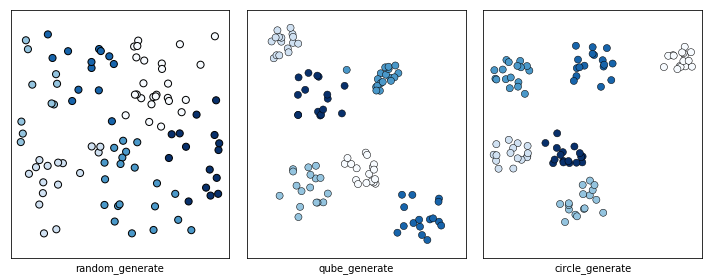

In [52]:
blobs1_clast = KMeans(sys=blobs1, sys_size=n_data, centers=n_cent)
blobs2_clast = KMeans(sys=blobs2, sys_size=n_data, centers=n_cent)
blobs3_clast = KMeans(sys=blobs3, sys_size=n_data, centers=n_cent)

figure = plt.figure(figsize=(10, 4))

plt.subplot(131)
plt.scatter(blobs1[:, 0], blobs1[:, 1], c=blobs1_clast, s=50, cmap='Blues', edgecolors='black', linewidth=1.0)
plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.xlabel('random_generate')
plt.subplot(132)
plt.scatter(blobs2[:, 0], blobs2[:, 1], c=blobs2_clast, s=50, cmap='Blues', edgecolors='black', linewidth=0.5)
plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.xlabel('qube_generate')
plt.subplot(133)
plt.scatter(blobs3[:, 0], blobs3[:, 1], c=blobs3_clast, s=50, cmap='Blues', edgecolors='black', linewidth=0.5)
plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.xlabel('circle_generate')
plt.tight_layout()

# Выбор числа кластеров

In [103]:
def auto_KMeans(sys, sys_size):
    minimal_claster_dist = (int(sys_size * (sys_size - 1) / 9)) + sys_size
    distance = (sys[:, 0][:, np.newaxis] - sys[:, 0]) ** 2
    distance += (sys[:, 1][:, np.newaxis] - sys[:, 1]) ** 2
    distance = np.sqrt(distance)
    minimal_claster_dist = np.sort(distance.ravel())[minimal_claster_dist]
    minimal_claster_dist *= 0.72
    distance[distance <= minimal_claster_dist] = 0
    dist_copy = np.zeros(sys_size * sys_size).reshape(sys_size, sys_size)
    while True:
        for i in range(sys_size):
            zero_dist = distance[distance [i, :] == 0]
            zero_dist = np.min(zero_dist, axis=0)
            dist_copy[i, :] = zero_dist
        if np.array_equal(dist_copy, distance):
            break
        distance = dist_copy.copy()
    distance[distance != 0] = 1
    return len(np.sum(np.unique(distance, axis=0), axis=1))

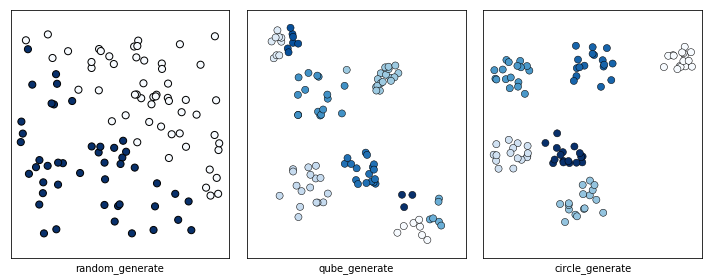

In [104]:
n_cent_blobs1 = auto_KMeans(sys = blobs1, sys_size=n_data)
blobs1_clast = KMeans(sys=blobs1, sys_size=n_data, centers=n_cent_blobs1)
n_cent_blobs2 = auto_KMeans(sys = blobs2, sys_size=n_data)
blobs2_clast = KMeans(sys=blobs2, sys_size=n_data, centers=n_cent_blobs2)
n_cent_blobs3 = auto_KMeans(sys = blobs3, sys_size=n_data)
blobs3_clast = KMeans(sys=blobs3, sys_size=n_data, centers=n_cent_blobs3)

figure = plt.figure(figsize=(10, 4))

plt.subplot(131)
plt.scatter(blobs1[:, 0], blobs1[:, 1], c=blobs1_clast, s=50, cmap='Blues', edgecolors='black', linewidth=1.0)
plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.xlabel('random_generate')
plt.subplot(132)
plt.scatter(blobs2[:, 0], blobs2[:, 1], c=blobs2_clast, s=50, cmap='Blues', edgecolors='black', linewidth=0.5)
plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.xlabel('qube_generate')
plt.subplot(133)
plt.scatter(blobs3[:, 0], blobs3[:, 1], c=blobs3_clast, s=50, cmap='Blues', edgecolors='black', linewidth=0.5)
plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.xlabel('circle_generate')
plt.tight_layout()

# Визуализация матрицы попарных расстояний

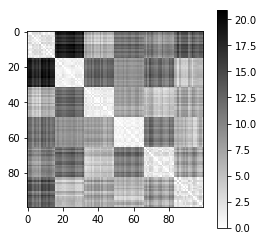

In [101]:
distance = (blobs2[:, 0][:, np.newaxis] - blobs2[:, 0]) ** 2
distance += (blobs2[:, 1][:, np.newaxis] - blobs2[:, 1]) ** 2
distance = np.sqrt(distance)

plt.figure(figsize=(4, 4))
plt.imshow(distance, cmap='binary')
plt.colorbar(orientation='vertical', pad=0.06);

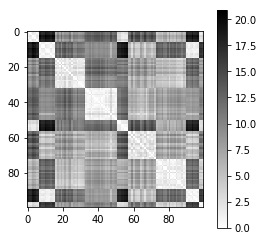

In [100]:
blobs = blobs2[np.argsort(blobs2_clast) ,:]
distance = (blobs[:, 0][:, np.newaxis] - blobs[:, 0]) ** 2
distance += (blobs[:, 1][:, np.newaxis] - blobs[:, 1]) ** 2
distance = np.sqrt(distance)

plt.figure(figsize=(4, 4))
plt.imshow(distance, cmap='binary')
plt.colorbar(orientation='vertical', pad=0.06);